In [1]:
import warnings
warnings.filterwarnings("ignore") 

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from datetime import timedelta,datetime
df=pd.read_csv('C:\\workplace\\electricity_demand\\dataset\\AEP_hourly.csv')
df.columns=['date_time','aep_mw']
df['date_time']=pd.to_datetime(df['date_time'])
df.sort_values('date_time',ascending=True,inplace=True)
df['date_time']=df['date_time'].astype(str)

In [3]:
df.head()

date_time   aep_mw
2183  2004-10-01 01:00:00  12379.0
2184  2004-10-01 02:00:00  11935.0
2185  2004-10-01 03:00:00  11692.0
2186  2004-10-01 04:00:00  11597.0
2187  2004-10-01 05:00:00  11681.0

In [4]:
def preparion_train (df,num_lags,lag_feature):

    df_lags=pd.DataFrame(index=df.index,columns=['lags_{}'.format(i) for i in range(num_lags)])
    df_day=pd.DataFrame(index=df.index,columns=['sin_day','cos_day'])
    df_day['sin_day']=np.sin(2*np.pi*pd.to_datetime(df['date_time']).dt.day_of_year/366)
    df_day['cos_day']=np.cos(2*np.pi*pd.to_datetime(df['date_time']).dt.day_of_year/366)
    df_day['sin_weekday']=np.sin(2*np.pi*pd.to_datetime(df['date_time']).dt.weekday/7)
    df_day['cos_weekday']=np.cos(2*np.pi*pd.to_datetime(df['date_time']).dt.weekday/7)
    df_day['sin_hour']=np.sin(2*np.pi*pd.to_datetime(df['date_time']).dt.hour/24)
    df_day['cos_hour']=np.cos(2*np.pi*pd.to_datetime(df['date_time']).dt.hour/24)

    df_target=pd.DataFrame(index=df.index,columns=['target'])
    df_target['target']=df[lag_feature].shift(-1)
    for i in range(num_lags):
        df_lags['lags_{}'.format(i)]=df[lag_feature].shift(i)
    
    df_processed=pd.concat([df_target,df_day,df_lags],axis=1)
    df_processed.index=df['date_time']

    return df_processed.dropna()

In [5]:
train_df=df[df['date_time']<='2017-08-02 23:00:00']

In [6]:
train_process=preparion_train(train_df,168*4,'aep_mw')

In [7]:
X_train=train_process.drop('target',axis=1)
y_train=train_process['target']

In [8]:
X_train.head()

sin_day   cos_day  sin_weekday  cos_weekday  sin_hour  \
date_time                                                                     
2004-10-29 00:00:00 -0.882679  0.469977    -0.433884    -0.900969  0.000000   
2004-10-29 01:00:00 -0.882679  0.469977    -0.433884    -0.900969  0.258819   
2004-10-29 02:00:00 -0.882679  0.469977    -0.433884    -0.900969  0.500000   
2004-10-29 03:00:00 -0.882679  0.469977    -0.433884    -0.900969  0.707107   
2004-10-29 04:00:00 -0.882679  0.469977    -0.433884    -0.900969  0.866025   

                     cos_hour   lags_0   lags_1   lags_2   lags_3  ...  \
date_time                                                          ...   
2004-10-29 00:00:00  1.000000  13355.0  14353.0  15309.0  15581.0  ...   
2004-10-29 01:00:00  0.965926  12510.0  13355.0  14353.0  15309.0  ...   
2004-10-29 02:00:00  0.866025  12022.0  12510.0  13355.0  14353.0  ...   
2004-10-29 03:00:00  0.707107  11753.0  12022.0  12510.0  13355.0  ...   
2004-10-29 04:00:00  0.500000  11530.0  11753.0  12022.0  12510.0  ...   

                     lags_662  lags_663  lags_664  lags_665  lags_666  \
date_time                                                               
2004-10-29 00:00:00   15118.0   14903.0   14618.0   13692.0   12280.0   
2004-10-29 01:00:00   15242.0   15118.0   14903.0   14618.0   13692.0   
2004-10-29 02:00:00   15375.0   15242.0   15118.0   14903.0   14618.0   
2004-10-29 03:00:00   15404.0   15375.0   15242.0   15118.0   14903.0   
2004-10-29 04:00:00   15655.0   15404.0   15375.0   15242.0   15118.0   

                     lags_667  lags_668  lags_669  lags_670  lags_671  
date_time                                                              
2004-10-29 00:00:00   11681.0   11597.0   11692.0   11935.0   12379.0  
2004-10-29 01:00:00   12280.0   11681.0   11597.0   11692.0   11935.0  
2004-10-29 02:00:00   13692.0   12280.0   11681.0   11597.0   11692.0  
2004-10-29 03:00:00   14618.0   13692.0   12280.0   11681.0   11597.0  
2004-10-29 04:00:00   14903.0   14618.0   13692.0   12280.0   11681.0  

[5 rows x 678 columns]

In [9]:
y_train

date_time
2004-10-29 00:00:00    12510.0
2004-10-29 01:00:00    12022.0
2004-10-29 02:00:00    11753.0
2004-10-29 03:00:00    11530.0
2004-10-29 04:00:00    11744.0
                        ...   
2017-08-02 18:00:00    19151.0
2017-08-02 19:00:00    18495.0
2017-08-02 20:00:00    17771.0
2017-08-02 21:00:00    17220.0
2017-08-02 22:00:00    16100.0
Name: target, Length: 111840, dtype: float64

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler().fit(X_train)
X_train_num=scaler.transform(X_train)
y_train_num=np.array(y_train).reshape(-1)

# Training the model

## Hyperparameter parameter tuning

In [ ]:
from sklearn.model_selection import train_test_split
X_fit,X_val,y_fit,y_val=train_test_split(X_train_num,y_train_num,test_size=0.3,shuffle=True)

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM,Dense,Input
from tensorflow.keras.losses import MeanAbsoluteError 
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model=Sequential()
model.add(Input((X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(),loss='mse',metrics=[MeanAbsolutePercentageError()])
stoppage=EarlyStopping(patience=50)
model.fit(X_fit,y_fit,validation_data=(X_val,y_val),epochs=3000,callbacks=[stoppage])

In [ ]:
val_df=pd.DataFrame(model.history.history)

In [ ]:
val_df.columns

In [ ]:
val_df[[ 'mean_absolute_percentage_error','val_mean_absolute_percentage_error']].plot()

In [ ]:
np.argmin(val_df['val_mean_absolute_percentage_error'])

In [ ]:
np.min(val_df['val_mean_absolute_percentage_error'])

In [ ]:
import plotly.express as px 
px.line(val_df,y='val_mean_absolute_percentage_error')

## Fitting a final model

In [ ]:
model=Sequential()
model.add(Input((X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(),loss=MeanAbsoluteError())
#stoppage=EarlyStopping(patience=50)
model.fit(X_train_num,y_train,epochs=500)

In [ ]:
from keras.models import load_model

model.save('C:\\workplace\\electricity_demand\\models\\mlp.h5')

# One step ahead forecast

In [11]:
from tensorflow.keras.models import load_model
model=load_model('C:\\workplace\\electricity_demand\\models\\mlp.h5')

In [12]:
X_test=preparion_train(df,168*4,'aep_mw')
X_test.reset_index(inplace=True)
y_test=np.array(X_test.loc[X_test['date_time']>'2017-08-02 23:00:00','target']).reshape(-1)
X_test=X_test[X_test['date_time']>'2017-08-02 23:00:00'].drop(['date_time','target'],axis=1)
X_test=scaler.transform(X_test)
pred=model.predict(X_test)

274/274 [==============================] - 1s 2ms/step


In [13]:
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error 
mean_absolute_error(y_test,pred),mean_absolute_percentage_error(y_test,pred)

(102.84658035905395, 0.006920100695905821)

In [14]:
index_test=preparion_train(df,168*4,'aep_mw').reset_index()
index_test['date_time']=index_test['date_time'].astype(str)
index_test=index_test[index_test['date_time']>'2017-08-02 23:00:00']['date_time']

<Axes: xlabel='date_time'>

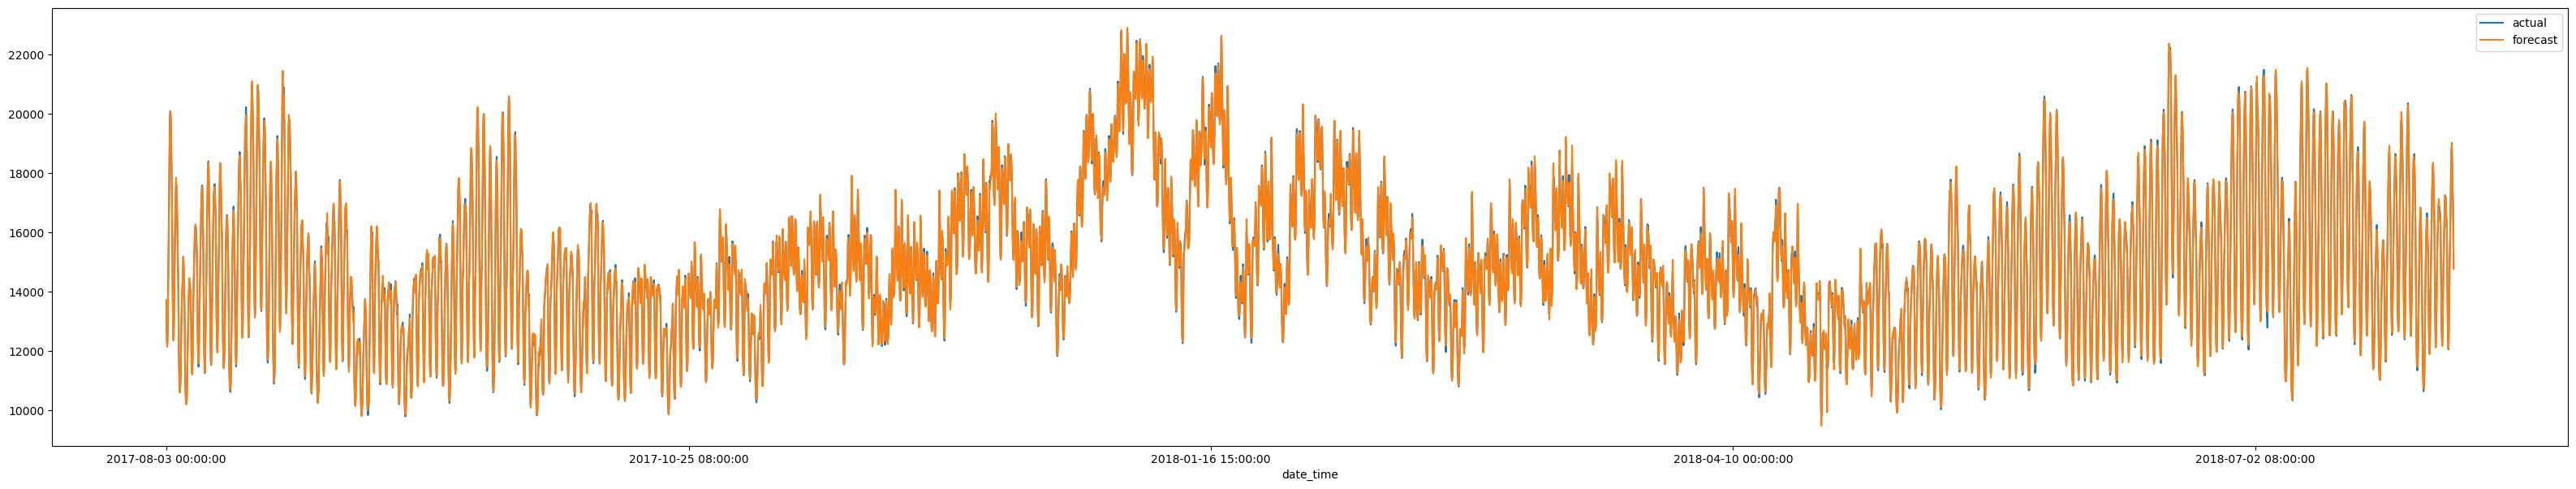

In [15]:
one_step_df=pd.concat([pd.Series(y_test,index=index_test),pd.Series(pred.reshape(-1),index=index_test)],axis=1)
one_step_df.columns=['actual','forecast']
one_step_df.plot(figsize=(40,7))

In [16]:
import plotly.graph_objects as go 
figure=go.Figure()
figure.add_trace(go.Scatter(x=one_step_df.index,y=one_step_df['actual'],name='actual'))
figure.add_trace(go.Scatter(x=one_step_df.index,y=one_step_df['forecast'],name='forecast'))

# Dayahead forecast

In [17]:
def dayahead_forecast(df,selected_time):
    test_df=df[df['date_time']<=selected_time]
    test_df=preparion_train(test_df,168*4,'aep_mw').drop('target',axis=1)
    test_df=test_df.tail(1)
    test_df.index=[0]
    pred_df=pd.DataFrame(index=range(1,48),columns=['date_time','forecast'])
    
    for i in range(1,48):
        forecast_for_time=str(datetime.fromisoformat(selected_time)+timedelta(hours=i))
        new_X=scaler.transform(test_df)
        pred_df.loc[i,'date_time']=forecast_for_time
        pred=model.predict(new_X,verbose=False)[0][0]
        pred_df.loc[i,'forecast']=pred

        test_dflags=test_df[test_df.columns[list(test_df.columns.str.contains('lags'))]]
        test_dflags=test_dflags.shift(1,axis=1)
        test_dflags.loc[0,'lags_0']=pred

        test_dftimes=test_df[test_df.columns[list(test_df.columns.str.contains('lags')==False)]]
        test_dftimes['date_time']=forecast_for_time=str(datetime.fromisoformat(selected_time)+timedelta(hours=i))
        test_dftimes['sin_day']=np.sin(2*np.pi*pd.to_datetime(test_dftimes['date_time']).dt.day_of_year/366)
        test_dftimes['cos_day']=np.cos(2*np.pi*pd.to_datetime(test_dftimes['date_time']).dt.day_of_year/366)
        test_dftimes['sin_weekday']=np.sin(2*np.pi*pd.to_datetime(test_dftimes['date_time']).dt.weekday/7)
        test_dftimes['cos_weekday']=np.cos(2*np.pi*pd.to_datetime(test_dftimes['date_time']).dt.weekday/7)
        test_dftimes['sin_hour']=np.sin(2*np.pi*pd.to_datetime(test_dftimes['date_time']).dt.hour/24)
        test_dftimes['cos_hour']=np.cos(2*np.pi*pd.to_datetime(test_dftimes['date_time']).dt.hour/24)
        test_dftimes.drop('date_time',axis=1,inplace=True)


        test_df=pd.concat([test_dftimes,test_dflags],axis=1)
        test_df=test_df.tail(1)
        test_df.index=[0]
    
    pred_df=pred_df.merge(df,on='date_time')
    pred_df=pred_df[['date_time','aep_mw','forecast']]
    pred_df.index=pred_df['date_time']
    pred_df.drop('date_time',axis=1,inplace=True)

    return pred_df

In [22]:
triggered_time=df.loc[(pd.to_datetime(df['date_time']).dt.hour==8) & (df['date_time']>'2017-08-02 23:00:00'),'date_time'].astype(str)
triggered_time

110986    2017-08-03 08:00:00
110962    2017-08-04 08:00:00
110938    2017-08-05 08:00:00
110914    2017-08-06 08:00:00
110890    2017-08-07 08:00:00
                 ...         
116241    2018-07-29 08:00:00
116217    2018-07-30 08:00:00
116193    2018-07-31 08:00:00
116169    2018-08-01 08:00:00
116145    2018-08-02 08:00:00
Name: date_time, Length: 365, dtype: object

In [23]:
pred_df=pd.DataFrame()
for i in triggered_time:
    temp=dayahead_forecast(df,i)
    pred_df=pd.concat([pred_df,temp.iloc[16:40]])
    print(i)

2017-08-03 08:00:00
2017-08-04 08:00:00
2017-08-05 08:00:00
2017-08-06 08:00:00
2017-08-07 08:00:00
2017-08-08 08:00:00
2017-08-09 08:00:00
2017-08-10 08:00:00
2017-08-11 08:00:00
2017-08-12 08:00:00
2017-08-13 08:00:00
2017-08-14 08:00:00
2017-08-15 08:00:00
2017-08-16 08:00:00
2017-08-17 08:00:00
2017-08-18 08:00:00
2017-08-19 08:00:00
2017-08-20 08:00:00
2017-08-21 08:00:00
2017-08-22 08:00:00
2017-08-23 08:00:00
2017-08-24 08:00:00
2017-08-25 08:00:00
2017-08-26 08:00:00
2017-08-27 08:00:00
2017-08-28 08:00:00
2017-08-29 08:00:00
2017-08-30 08:00:00
2017-08-31 08:00:00
2017-09-01 08:00:00
2017-09-02 08:00:00
2017-09-03 08:00:00
2017-09-04 08:00:00
2017-09-05 08:00:00
2017-09-06 08:00:00
2017-09-07 08:00:00
2017-09-08 08:00:00
2017-09-09 08:00:00
2017-09-10 08:00:00
2017-09-11 08:00:00
2017-09-12 08:00:00
2017-09-13 08:00:00
2017-09-14 08:00:00
2017-09-15 08:00:00
2017-09-16 08:00:00
2017-09-17 08:00:00
2017-09-18 08:00:00
2017-09-19 08:00:00
2017-09-20 08:00:00
2017-09-21 08:00:00


In [26]:
mean_absolute_percentage_error(pred_df['aep_mw'],pred_df['forecast'])

0.07298152531723409

In [25]:
figure=go.Figure()
figure.add_trace(go.Scatter(x=df['date_time'].astype(str),y=df['aep_mw'],name='actual_electricity_load'))
figure.add_trace(go.Scatter(x=pred_df.index,y=pred_df['forecast'],name='mlp_forecast'))

<Axes: xlabel='date_time'>

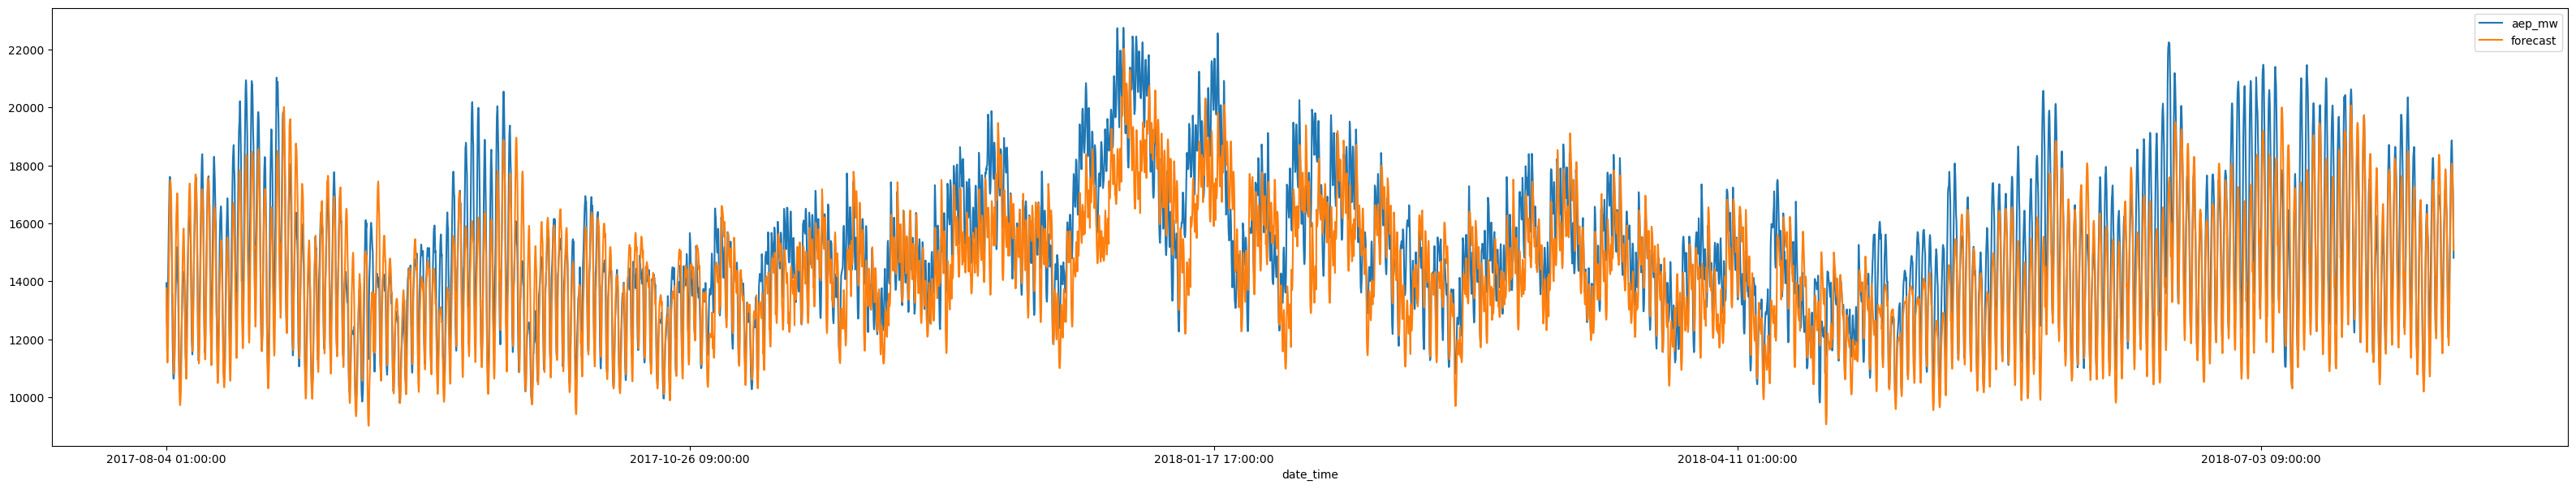

In [29]:
pred_df.plot(figsize=(40,7))

## Warm up 